## Importing libraries and packages

In [9]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import math # Needed for pi


## 1. Loading data :
Loading a single image, pose, and camera intrinsics from the Blender ficus dataset.
    

Image Shape: (128, 128, 3)

Camera-to-World Pose Matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 4.]
 [0. 0. 0. 1.]]

Calculated Focal Length: 110.85125168440815


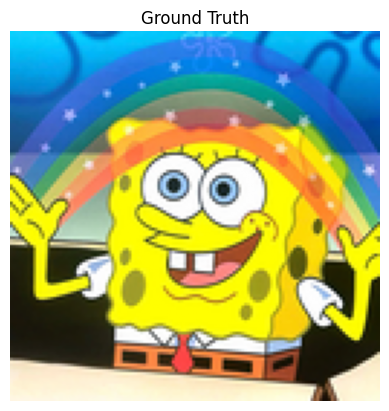

In [10]:
def load_image_with_pose(dataset_dir, img_size=(128, 128)):

    # 1. Define a generic camera field of view (FOV).
    # 60 degrees is a common value. We convert it to radians.
    fov_degrees = 60.0
    camera_angle_x = fov_degrees * (math.pi / 180.0)

    # 2. Define a generic camera-to-world pose matrix.
    # This pose places the camera at (0, 0, 4) and looks towards the origin.
    transform_matrix = [
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 4.0],
        [0.0, 0.0, 0.0, 1.0]
    ]

    img = 'imagination.png'

    # 2. Construct the full path to the image file.
    img_path = os.path.join(dataset_dir, img)

    # 3. Load and process the image (same as before).
    image = Image.open(img_path).resize(img_size, Image.LANCZOS)
    image = np.array(image) / 255.0 # Normalize to [0, 1]

    # Extract RGB channels (assumes input is RGBA).
    rgb = image[..., :3]

    # The pose is the camera-to-world transformation matrix.
    pose = np.array(transform_matrix)

    # The focal length is calculated from the camera's horizontal field of view.
    focal = 0.5 * img_size[0] / np.tan(0.5 * camera_angle_x)

    return rgb, pose, focal


# Path to the base directory of your dataset.
dataset_base_dir = 'data/'

# Load the image and its corresponding, hardcoded camera data.
image, camera_to_world, focal_length = load_image_with_pose(dataset_base_dir, img_size=(128, 128))
height, width = image.shape[:2]

# Print the loaded data to verify
print("Image Shape:", image.shape)
print("\nCamera-to-World Pose Matrix:\n", camera_to_world)
print("\nCalculated Focal Length:", focal_length)

# Display the image
plt.imshow(image)
plt.title('Ground Truth')
plt.axis('off')
plt.show()

## 2. Ray Generation
This step connects the 2D image to the 3D world. For every pixel in the 128x128 image, it calculates a unique 3D ray.
Each ray has an origin (the camera's 3D location) and a direction vector that points from the camera, through that pixel and out into the scene. That results in a set of 16,384 rays, one for each pixel

In [11]:
def generate_camera_rays(height, width, focal_length, camera_to_world):
    # Create a grid of pixel coordinates (i: x-axis, j: y-axis)
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

    # Compute ray directions in camera space
    x = (i - width / 2) / focal_length
    y = -(j - height / 2) / focal_length
    z = -np.ones_like(x)
    directions_camera = np.stack([x, y, z], axis=-1)  # Shape: (H, W, 3) and each (x, y, z) triplet represents the direction of a ray originating from the camera's origin,

    # Transform ray directions from the camera space to world space
    directions_world = directions_camera @ camera_to_world[:3, :3].T

    # All rays originate from the camera origin in world space
    origins_world = np.broadcast_to(camera_to_world[:3, 3], directions_world.shape)

    return origins_world, directions_world

ray_origins, ray_directions = generate_camera_rays(height, width, focal_length, camera_to_world)


## 3. Point Sampling Along Rays
The neural network needs 3D points to evaluate, not just rays. This function takes each of the 16,384 rays and samples 32 distinct 3D points (x, y, z) along its path.
These points are spaced evenly between a near and a far boundary, defining the volume in space where the object is expected to be.


In [12]:

def sample_points_along_rays(ray_origins, ray_directions, near, far, num_samples):
    z_values = np.linspace(near, far, num_samples)
    points = ray_origins[..., None, :] + ray_directions[..., None, :] * z_values[None, None, :, None] # A point P along a ray can be expressed as: P = O + t⋅D
    return points, z_values

num_samples_per_ray = 32
near_bound, far_bound = 2.0, 6.0
sampled_points, z_values = sample_points_along_rays(ray_origins, ray_directions, near_bound, far_bound, num_samples_per_ray)


In [13]:

# def positional_encoding(x, num_freqs=6):
#     encoded_features = [x]
#     freqs = 2.**torch.arange(num_freqs, device=x.device) * torch.pi
#     for freq in freqs:
#         encoded_features.append(torch.sin(x * freq))
#         encoded_features.append(torch.cos(x * freq))
#     return torch.cat(encoded_features, dim=-1)

# # Example integration
# num_samples_per_ray = 32
# near_bound, far_bound = 2.0, 6.0

# # Sample points
# sampled_points, z_values = sample_points_along_rays(ray_origins, ray_directions, near_bound, far_bound, num_samples_per_ray)

# # Convert sampled points to torch tensor for positional encoding
# sampled_points_torch = torch.from_numpy(sampled_points).float()

# # Apply positional encoding
# encoded_points = positional_encoding(sampled_points_torch, num_freqs=6)

# # Now encoded_points can be passed into a neural network for further processing.


## Neural Network Definition
This is the core of the NeRF: a simple neural network. Its job is to act as a "function of the scene." It takes a single 3D coordinate (x, y, z) as input and predicts two things at that specific point in space: its color (r, g, b) and its density (sigma). A high density means the point is opaque, while a low density means it's transparent.

In [14]:
class NeRFNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 4)  # Output: (r, g, b, sigma)
        )

    def forward(self, x):
        return self.mlp(x)

# Instantiate the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeRFNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

## 5. Volume Rendering Function
Volume rendering simulates the way light passes through a semi-transparent medium (like fog, smoke, or 3D scenes) and accumulates color and opacity along a ray.

This is how an image is created from the Neural Network's predictions. For a single ray, it takes the 32 predicted colors and densities from the sampled points. Using the volume rendering equation, it composites them together, correctly blending the colors based on their density and distance. Points closer to the camera can block (occlude) points further away. The final output is a single pixel color for that ray.



In [15]:


def volume_render_radiance_field(rgb_sigma, z_values, ray_directions):
    """
    Args:
        rgb_sigma (Tensor): Raw output from the network of shape (num_rays, num_samples, 4).
                            The last channel is sigma (density), and the first three are RGB.
        z_values (Tensor): Sampled depth values along each ray, shape (num_samples,).
        ray_directions (Tensor): Ray directions, shape (num_rays, 3).

    Returns:
        rgb_map (Tensor): Rendered RGB color for each ray, shape (num_rays, 3).
    """
    # Separate RGB and density (sigma), applying activation functions
    rgb = torch.sigmoid(rgb_sigma[..., :3])          # (num_rays, num_samples, 3)
    # sigma = F.relu(rgb_sigma[..., 3])                # (num_rays, num_samples)
    sigma = F.softplus(rgb_sigma[..., 3])    # (num_rays, num_samples)

    # Compute distances between consecutive samples along each ray
    dists = z_values[1:] - z_values[:-1]             # (num_samples - 1,)
    dists = torch.cat([dists, torch.tensor([1e10], device=z_values.device)])  # (num_samples,)
    dists = dists.unsqueeze(0).expand(ray_directions.shape[0], -1)            # (num_rays, num_samples)

    # Scale distances by the length of each ray
    ray_lengths = torch.norm(ray_directions, dim=-1, keepdim=True)           # (num_rays, 1)
    dists = dists * ray_lengths                                              # (num_rays, num_samples)

    # Compute alpha values from sigma
    alpha = 1.0 - torch.exp(-sigma * dists)                                  # (num_rays, num_samples)

    # Compute transmittance (T) and sample weights
    T = torch.cumprod(
        torch.cat([
            torch.ones((alpha.shape[0], 1), device=alpha.device),
            1.0 - alpha + 1e-10
        ], dim=-1),
        dim=-1
    )[:, :-1]

    weights = alpha * T                                                      # (num_rays, num_samples)

    # Composite RGB values using the weights
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)                    # (num_rays, 3)

    return rgb_map


## 6. Prepare Training Data
To train efficiently on a GPU, the data (sampled points, ray directions, and target pixel colors) is "flattened" from 120x120 structure into long, one-dimensional lists.
It also converts the NumPy arrays into PyTorch Tensors.

In [16]:

# Flatten rays and image for batch processing
num_rays = height * width

points_flat = torch.from_numpy(sampled_points.reshape(-1, num_samples_per_ray, 3)).float().to(device)
ray_directions_flat = torch.from_numpy(ray_directions.reshape(-1, 3)).float().to(device)
target_rgb_flat = torch.from_numpy(image.reshape(-1, 3)).float().to(device)

z_values_tensor = torch.from_numpy(z_values).float().to(device)



In [17]:

# # Convert sampled points to tensor and apply positional encoding
# sampled_points_tensor = torch.from_numpy(sampled_points).float().to(device)
# encoded_points = positional_encoding(sampled_points_tensor, num_freqs=6)

# # Flatten the encoded points for batch processing
# points_flat = encoded_points.reshape(-1, num_samples_per_ray, encoded_points.shape[-1])

# ray_directions_flat = torch.from_numpy(ray_directions.reshape(-1, 3)).float().to(device)
# target_rgb_flat = torch.from_numpy(image.reshape(-1, 3)).float().to(device)

# z_values_tensor = torch.from_numpy(z_values).float().to(device)


## 7. Training Loop
This is where the learning happens. The loop repeats num_training_steps times, and in each step it:
- Forward Pass: Feeds all the sampled 3D points to the MLP to get color and density predictions.
- Render: Uses the volume rendering function to turn those predictions into a full image.
- Calculate Loss: Compares the rendered image with the ground truth image using Mean Squared Error (MSE) to see how "wrong" the prediction is.
- Optimize: Uses the error to calculate how to adjust the MLP's weights to make a better prediction in the next step (this is backpropagation).

In [20]:

num_training_steps = 10000
for step in tqdm(range(num_training_steps), desc="Training NeRF"):
    # Predict color and density for all points along all rays
    rgb_sigma = model(points_flat)  # (num_rays, num_samples, 4)
    rgb_sigma = rgb_sigma.view(-1, num_samples_per_ray, 4)

    # Volume render to get final pixel colors
    rendered_rgb = volume_render_radiance_field(rgb_sigma, z_values_tensor, ray_directions_flat)

    # Compute loss
    loss = F.mse_loss(rendered_rgb, target_rgb_flat)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f"Step {step:4d} | Loss: {loss.item():.6f}")


Training NeRF:   0%|          | 8/10000 [00:00<04:11, 39.75it/s]

Step    0 | Loss: 0.017904


Training NeRF:   1%|          | 108/10000 [00:02<03:24, 48.27it/s]

Step  100 | Loss: 0.017437


Training NeRF:   2%|▏         | 208/10000 [00:04<03:26, 47.32it/s]

Step  200 | Loss: 0.017380


Training NeRF:   3%|▎         | 308/10000 [00:06<03:33, 45.34it/s]

Step  300 | Loss: 0.016965


Training NeRF:   4%|▍         | 408/10000 [00:08<03:18, 48.22it/s]

Step  400 | Loss: 0.017217


Training NeRF:   5%|▌         | 508/10000 [00:10<03:23, 46.74it/s]

Step  500 | Loss: 0.016849


Training NeRF:   6%|▌         | 608/10000 [00:13<03:19, 47.01it/s]

Step  600 | Loss: 0.017164


Training NeRF:   7%|▋         | 708/10000 [00:15<03:15, 47.49it/s]

Step  700 | Loss: 0.017021


Training NeRF:   8%|▊         | 808/10000 [00:17<03:14, 47.30it/s]

Step  800 | Loss: 0.016952


Training NeRF:   9%|▉         | 908/10000 [00:19<03:12, 47.15it/s]

Step  900 | Loss: 0.016631


Training NeRF:  10%|█         | 1008/10000 [00:21<03:09, 47.37it/s]

Step 1000 | Loss: 0.017117


Training NeRF:  11%|█         | 1108/10000 [00:23<03:10, 46.71it/s]

Step 1100 | Loss: 0.016606


Training NeRF:  12%|█▏        | 1208/10000 [00:25<03:08, 46.71it/s]

Step 1200 | Loss: 0.017000


Training NeRF:  13%|█▎        | 1308/10000 [00:27<03:05, 46.95it/s]

Step 1300 | Loss: 0.016368


Training NeRF:  14%|█▍        | 1408/10000 [00:29<03:02, 47.06it/s]

Step 1400 | Loss: 0.017185


Training NeRF:  15%|█▌        | 1508/10000 [00:32<03:01, 46.73it/s]

Step 1500 | Loss: 0.016270


Training NeRF:  16%|█▌        | 1608/10000 [00:34<03:12, 43.56it/s]

Step 1600 | Loss: 0.016730


Training NeRF:  17%|█▋        | 1708/10000 [00:36<02:57, 46.66it/s]

Step 1700 | Loss: 0.017137


Training NeRF:  18%|█▊        | 1808/10000 [00:38<02:54, 46.91it/s]

Step 1800 | Loss: 0.016395


Training NeRF:  19%|█▉        | 1908/10000 [00:40<02:52, 46.87it/s]

Step 1900 | Loss: 0.016104


Training NeRF:  20%|██        | 2008/10000 [00:42<02:49, 47.04it/s]

Step 2000 | Loss: 0.016067


Training NeRF:  21%|██        | 2108/10000 [00:45<03:01, 43.55it/s]

Step 2100 | Loss: 0.016032


Training NeRF:  22%|██▏       | 2208/10000 [00:47<02:43, 47.75it/s]

Step 2200 | Loss: 0.015942


Training NeRF:  23%|██▎       | 2308/10000 [00:49<02:42, 47.35it/s]

Step 2300 | Loss: 0.016511


Training NeRF:  24%|██▍       | 2408/10000 [00:51<02:38, 47.85it/s]

Step 2400 | Loss: 0.016501


Training NeRF:  25%|██▌       | 2508/10000 [00:53<02:36, 47.82it/s]

Step 2500 | Loss: 0.016399


Training NeRF:  26%|██▌       | 2608/10000 [00:55<02:35, 47.52it/s]

Step 2600 | Loss: 0.016678


Training NeRF:  27%|██▋       | 2708/10000 [00:57<02:32, 47.72it/s]

Step 2700 | Loss: 0.016383


Training NeRF:  28%|██▊       | 2808/10000 [00:59<02:30, 47.74it/s]

Step 2800 | Loss: 0.015775


Training NeRF:  29%|██▉       | 2908/10000 [01:02<02:33, 46.24it/s]

Step 2900 | Loss: 0.016388


Training NeRF:  30%|███       | 3008/10000 [01:04<02:27, 47.52it/s]

Step 3000 | Loss: 0.016534


Training NeRF:  31%|███       | 3108/10000 [01:06<02:23, 47.98it/s]

Step 3100 | Loss: 0.016588


Training NeRF:  32%|███▏      | 3208/10000 [01:08<02:23, 47.23it/s]

Step 3200 | Loss: 0.016353


Training NeRF:  33%|███▎      | 3308/10000 [01:10<02:20, 47.63it/s]

Step 3300 | Loss: 0.016385


Training NeRF:  34%|███▍      | 3408/10000 [01:12<02:17, 47.93it/s]

Step 3400 | Loss: 0.016795


Training NeRF:  35%|███▌      | 3508/10000 [01:14<02:18, 47.01it/s]

Step 3500 | Loss: 0.016399


Training NeRF:  36%|███▌      | 3608/10000 [01:16<02:13, 47.90it/s]

Step 3600 | Loss: 0.016576


Training NeRF:  37%|███▋      | 3708/10000 [01:18<02:12, 47.63it/s]

Step 3700 | Loss: 0.015841


Training NeRF:  38%|███▊      | 3808/10000 [01:20<02:08, 48.03it/s]

Step 3800 | Loss: 0.016179


Training NeRF:  39%|███▉      | 3908/10000 [01:23<02:08, 47.49it/s]

Step 3900 | Loss: 0.015976


Training NeRF:  40%|████      | 4008/10000 [01:25<02:05, 47.71it/s]

Step 4000 | Loss: 0.015584


Training NeRF:  41%|████      | 4108/10000 [01:27<02:05, 46.82it/s]

Step 4100 | Loss: 0.015543


Training NeRF:  42%|████▏     | 4208/10000 [01:29<02:01, 47.66it/s]

Step 4200 | Loss: 0.016097


Training NeRF:  43%|████▎     | 4308/10000 [01:31<01:59, 47.67it/s]

Step 4300 | Loss: 0.015773


Training NeRF:  44%|████▍     | 4408/10000 [01:33<01:56, 47.84it/s]

Step 4400 | Loss: 0.015969


Training NeRF:  45%|████▌     | 4508/10000 [01:35<01:55, 47.73it/s]

Step 4500 | Loss: 0.015625


Training NeRF:  46%|████▌     | 4608/10000 [01:37<01:54, 47.00it/s]

Step 4600 | Loss: 0.015288


Training NeRF:  47%|████▋     | 4708/10000 [01:39<01:54, 46.38it/s]

Step 4700 | Loss: 0.015648


Training NeRF:  48%|████▊     | 4808/10000 [01:41<01:49, 47.46it/s]

Step 4800 | Loss: 0.015473


Training NeRF:  49%|████▉     | 4908/10000 [01:44<01:46, 47.64it/s]

Step 4900 | Loss: 0.015423


Training NeRF:  50%|█████     | 5008/10000 [01:46<01:45, 47.39it/s]

Step 5000 | Loss: 0.016445


Training NeRF:  51%|█████     | 5108/10000 [01:48<01:43, 47.22it/s]

Step 5100 | Loss: 0.015270


Training NeRF:  52%|█████▏    | 5208/10000 [01:50<01:42, 46.78it/s]

Step 5200 | Loss: 0.015233


Training NeRF:  53%|█████▎    | 5308/10000 [01:52<01:39, 47.15it/s]

Step 5300 | Loss: 0.015542


Training NeRF:  54%|█████▍    | 5408/10000 [01:54<01:37, 47.01it/s]

Step 5400 | Loss: 0.015166


Training NeRF:  55%|█████▌    | 5508/10000 [01:56<01:35, 46.99it/s]

Step 5500 | Loss: 0.015424


Training NeRF:  56%|█████▌    | 5608/10000 [01:58<01:33, 47.00it/s]

Step 5600 | Loss: 0.016335


Training NeRF:  57%|█████▋    | 5708/10000 [02:01<01:30, 47.29it/s]

Step 5700 | Loss: 0.015228


Training NeRF:  58%|█████▊    | 5808/10000 [02:03<01:29, 46.82it/s]

Step 5800 | Loss: 0.015234


Training NeRF:  59%|█████▉    | 5908/10000 [02:05<01:26, 47.27it/s]

Step 5900 | Loss: 0.015585


Training NeRF:  60%|██████    | 6008/10000 [02:07<01:24, 47.19it/s]

Step 6000 | Loss: 0.015986


Training NeRF:  61%|██████    | 6108/10000 [02:09<01:22, 47.23it/s]

Step 6100 | Loss: 0.015485


Training NeRF:  62%|██████▏   | 6208/10000 [02:11<01:20, 47.31it/s]

Step 6200 | Loss: 0.015413


Training NeRF:  63%|██████▎   | 6308/10000 [02:13<01:18, 47.19it/s]

Step 6300 | Loss: 0.015455


Training NeRF:  64%|██████▍   | 6408/10000 [02:15<01:16, 46.78it/s]

Step 6400 | Loss: 0.015474


Training NeRF:  65%|██████▌   | 6508/10000 [02:18<01:14, 46.83it/s]

Step 6500 | Loss: 0.015520


Training NeRF:  66%|██████▌   | 6608/10000 [02:20<01:11, 47.27it/s]

Step 6600 | Loss: 0.014957


Training NeRF:  67%|██████▋   | 6708/10000 [02:22<01:09, 47.27it/s]

Step 6700 | Loss: 0.015964


Training NeRF:  68%|██████▊   | 6808/10000 [02:24<01:07, 47.29it/s]

Step 6800 | Loss: 0.014898


Training NeRF:  69%|██████▉   | 6908/10000 [02:26<01:05, 47.23it/s]

Step 6900 | Loss: 0.015809


Training NeRF:  70%|███████   | 7008/10000 [02:28<01:03, 47.23it/s]

Step 7000 | Loss: 0.015275


Training NeRF:  71%|███████   | 7108/10000 [02:30<01:01, 47.11it/s]

Step 7100 | Loss: 0.015597


Training NeRF:  72%|███████▏  | 7208/10000 [02:32<00:59, 47.19it/s]

Step 7200 | Loss: 0.015357


Training NeRF:  73%|███████▎  | 7308/10000 [02:35<00:57, 47.12it/s]

Step 7300 | Loss: 0.015413


Training NeRF:  74%|███████▍  | 7408/10000 [02:37<00:54, 47.59it/s]

Step 7400 | Loss: 0.014830


Training NeRF:  75%|███████▌  | 7508/10000 [02:39<00:52, 47.58it/s]

Step 7500 | Loss: 0.015617


Training NeRF:  76%|███████▌  | 7608/10000 [02:41<00:51, 46.58it/s]

Step 7600 | Loss: 0.014871


Training NeRF:  77%|███████▋  | 7708/10000 [02:43<00:48, 47.59it/s]

Step 7700 | Loss: 0.015077


Training NeRF:  78%|███████▊  | 7808/10000 [02:45<00:46, 47.00it/s]

Step 7800 | Loss: 0.014947


Training NeRF:  79%|███████▉  | 7908/10000 [02:47<00:44, 47.41it/s]

Step 7900 | Loss: 0.016886


Training NeRF:  80%|████████  | 8008/10000 [02:49<00:41, 47.85it/s]

Step 8000 | Loss: 0.014681


Training NeRF:  81%|████████  | 8108/10000 [02:51<00:40, 47.21it/s]

Step 8100 | Loss: 0.014715


Training NeRF:  82%|████████▏ | 8208/10000 [02:54<00:38, 46.45it/s]

Step 8200 | Loss: 0.014914


Training NeRF:  83%|████████▎ | 8308/10000 [02:56<00:35, 47.13it/s]

Step 8300 | Loss: 0.015783


Training NeRF:  84%|████████▍ | 8408/10000 [02:58<00:33, 47.20it/s]

Step 8400 | Loss: 0.014961


Training NeRF:  85%|████████▌ | 8508/10000 [03:00<00:31, 47.48it/s]

Step 8500 | Loss: 0.015004


Training NeRF:  86%|████████▌ | 8608/10000 [03:02<00:29, 47.16it/s]

Step 8600 | Loss: 0.015632


Training NeRF:  87%|████████▋ | 8708/10000 [03:04<00:27, 46.64it/s]

Step 8700 | Loss: 0.015459


Training NeRF:  88%|████████▊ | 8808/10000 [03:06<00:25, 46.16it/s]

Step 8800 | Loss: 0.016172


Training NeRF:  89%|████████▉ | 8908/10000 [03:08<00:23, 47.39it/s]

Step 8900 | Loss: 0.015354


Training NeRF:  90%|█████████ | 9008/10000 [03:11<00:20, 47.53it/s]

Step 9000 | Loss: 0.015224


Training NeRF:  91%|█████████ | 9108/10000 [03:13<00:18, 47.45it/s]

Step 9100 | Loss: 0.014898


Training NeRF:  92%|█████████▏| 9208/10000 [03:15<00:16, 47.46it/s]

Step 9200 | Loss: 0.015413


Training NeRF:  93%|█████████▎| 9308/10000 [03:17<00:14, 46.48it/s]

Step 9300 | Loss: 0.016471


Training NeRF:  94%|█████████▍| 9408/10000 [03:19<00:12, 46.42it/s]

Step 9400 | Loss: 0.014654


Training NeRF:  95%|█████████▌| 9508/10000 [03:21<00:10, 46.89it/s]

Step 9500 | Loss: 0.014445


Training NeRF:  96%|█████████▌| 9608/10000 [03:23<00:08, 47.54it/s]

Step 9600 | Loss: 0.014468


Training NeRF:  97%|█████████▋| 9708/10000 [03:25<00:06, 47.23it/s]

Step 9700 | Loss: 0.014911


Training NeRF:  98%|█████████▊| 9808/10000 [03:28<00:04, 47.28it/s]

Step 9800 | Loss: 0.014593


Training NeRF:  99%|█████████▉| 9908/10000 [03:30<00:01, 46.51it/s]

Step 9900 | Loss: 0.015166


Training NeRF: 100%|██████████| 10000/10000 [03:32<00:00, 47.14it/s]


## 8. Visualization

After the training finishes, this final step takes the model's last rendered image, converts it back into a standard image format, and displays it next to the original ground truth image.


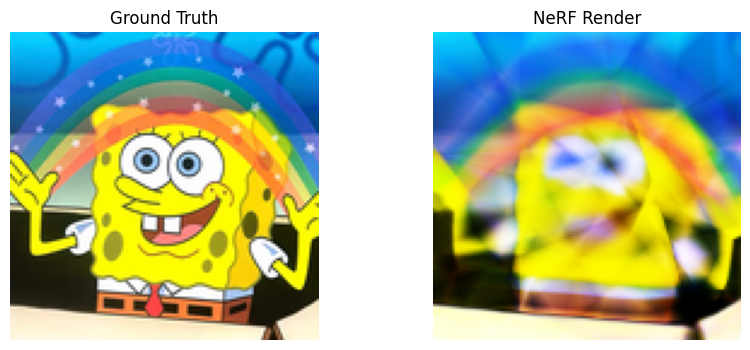

In [21]:
# Reshape the rendered image and display
rendered_image = rendered_rgb.detach().cpu().numpy().reshape(height, width, 3)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('NeRF Render')
plt.imshow(np.clip(rendered_image, 0, 1))
plt.axis('off')
plt.show()